## S6. Assessing the relationships between Biochemical Sector Cash Flow and Environmental Impacts

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
from __future__ import division

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import host_subplot

import numpy
import cPickle as pickle

from cbmTES.global_constants import *


from framed.analysis.variability import FVA, flux_envelope_3d
from framed.hack.ratio_constraint import *

In [3]:
### Flux Constraints ###
FCs = {}
FCs['no import'] = {'DM_glyc_mkt':(0,0), 'DM_glc_mkt':(0,0), 'DM_energy_mkt':(0,0)}
FCs['positive profits']= {'PROFIT_res':(0,None), 'PROFIT_agr':(0,None), 'PROFIT_erg':(0,None), 'PROFIT_bch':(0,None)}
FCs['product demand: pdo = 1000']= {'DM_3hp_mkt':(0, 0), 'DM_1,3pdo_mkt':(1000,1000)}
FCs['land use < 1'] = {'EX_land_res':(-1,0)}
FCs['land use < 5'] = {'EX_land_res':(-5,0)}
FCs['co2 < 3000'] = {'EX_co2e_mkt':(0, 3000)}
FCs['co2 < 2000'] = {'EX_co2e_mkt':(0, 2000)}

### Ratio Constraints ###
# EU Energy Mix
def add_RC_EU_energy(model):
    add_ratio_constraint(model, 'energy_from_petroleum', 'MX_erg2mkt_energy', 0.25)
    add_ratio_constraint(model, 'energy_from_natural_gas', 'MX_erg2mkt_energy', 0.7)
    add_ratio_constraint(model, 'energy_from_coal', 'MX_erg2mkt_energy', 0.05)
    
### Setting Up Scenarios ### 
base_scenario = {k:v for d in (FCs['no import'], FCs['positive profits']) for k, v in d.iteritems()}

# Scenario A: PDO production = 1 ton, Land use < 5 hectare
scenario_A = base_scenario.copy()
scenario_A.update(FCs['product demand: pdo = 1000'])
scenario_A.update(FCs['land use < 5'])

# Scenario B: PDO production = 1 ton, Land use < 1 hectare
scenario_B= base_scenario.copy()
scenario_B.update(FCs['product demand: pdo = 1000'])
scenario_B.update(FCs['land use < 1'])

# Scenario C: PDO production = 1 ton, CO2 < 2000 g
scenario_C= base_scenario.copy()
scenario_C.update(FCs['product demand: pdo = 1000'])
scenario_C.update(FCs['co2 < 2000'])
#scenario_C.update(FCs['co2 < 3000'])

In [4]:
# Loading Model
model = pickle.load(open('models/mini_BChI_model.pickle','rb'))
add_RC_EU_energy(model)  # add EU energy mixing constraint

In [5]:
# Simulate Scenario A
zmins_A, zmaxs_A, x_coors_A, y_coors_A = flux_envelope_3d(model, 'PROFIT_bch','EX_po4e_mkt','EX_co2e_mkt', steps=15, constraints=scenario_A)

# Simulate Scenario B
zmins_B, zmaxs_B, x_coors_B, y_coors_B = flux_envelope_3d(model, 'PROFIT_bch','EX_po4e_mkt','EX_co2e_mkt', steps=15, constraints=scenario_B)


# Simulate Scenario C
zmins_C, zmaxs_C, x_coors_C, y_coors_C = flux_envelope_3d(model, 'PROFIT_bch','EX_po4e_mkt','EX_co2e_mkt', steps=15, constraints=scenario_C)

xA = x_coors_A + x_coors_A
yA = y_coors_A + y_coors_A
zA = zmaxs_A + zmins_A

xB = x_coors_B + x_coors_B
yB = y_coors_B + y_coors_B
zB = zmaxs_B + zmins_B

xC = x_coors_C + x_coors_C
yC = y_coors_C + y_coors_C
zC = zmaxs_C + zmins_C

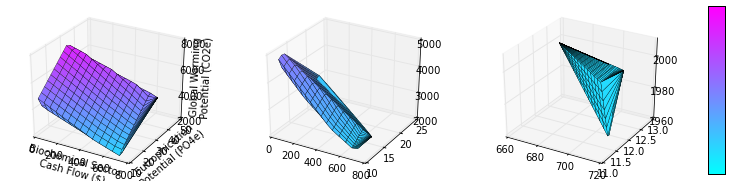

In [6]:
from mpl_toolkits.mplot3d import Axes3D
fig= plt.figure(1,figsize = (12,3))

my_cmap = plt.cm.get_cmap('cool')


ax = fig.add_subplot(131, projection='3d')
surf = ax.plot_surface(xA, yA, zA, cmap=my_cmap, rstride = 1, cstride = 1, linewidth=0.3, vmin = 1000, vmax = 8000)
ax.locator_params(nbins=4)

ax.set_xlabel('Biochemical Sector\nCash Flow ($)')
ax.set_ylabel('Eutrophication\nPotential (PO4e)')
ax.set_zlabel('Global Warming\nPotential (CO2e)')


ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(xB, yB, zB, cmap=my_cmap, rstride = 1, cstride = 1, linewidth=0.3, vmin = 1000, vmax = 8000)
ax.locator_params(nbins=4)

ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(xC, yC, zC, cmap=my_cmap, rstride = 1, cstride = 1, linewidth=0.3, vmin = 1000, vmax = 8000)
ax.locator_params(nbins=4)

cbar_ax = fig.add_axes([0.936, 0.125, 0.02, 0.775])
cbar=fig.colorbar(surf, cax=cbar_ax)
cbar_ax.tick_params(labelsize=5, left='off', right='off',top='off',labelright='off')
cbar.solids.set_edgecolor("face")

plt.savefig('figures/constraints_vs_solution_space3d.png', dpi=300)
plt.savefig('figures/constraints_vs_solution_space3d.svg')

In [7]:
x

225